**Importing required Librires**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, f1_score
import nltk
import re
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Importing data from a webpage**

In [ ]:
df= pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')

print('Shape before:', df.shape)
df = df.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df.shape)
display(df.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6 and seeing the head of the dataframe

In [ ]:
stopwords= stopwords.words('english')
def cleanText(text):
    text = re.sub(r'''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~''', r' ', text) 
    text = text.lower()
    text = text.replace(',', '')
    tokens = nltk.word_tokenize(text)
    wordlist = [] 
    for w in tokens:
      if w not in stopwords:
        if w.isalpha():
          wordlist.append(w)

    clean_text = ' '.join(wordlist)
    return clean_text
    
df['clean_text'] = df['text'].apply(cleanText)

Cleaning the Data using stopwords. First we select the language and then we remove the unwanted symbols. Then after, we remove the stop words like a, an is e.t.c

In [ ]:
def plot_confusion_matrix(y_true: np.ndarray, y_hat: np.ndarray, figsize = (15, 10)):
    labels = sorted(list(set(y_true)))
    df = pd.DataFrame(confusion_matrix(y_true, y_hat), index = labels, columns = labels)
    acc = accuracy_score(y_true, y_hat)
    f1s = f1_score(y_true, y_hat, average = 'weighted')
    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(df, annot = True, square = True, fmt = 'd', linewidths = 1,cbar = False, cmap = 'Paired', ax = ax)
    ax.set(title = f'Accuracy: {acc:.2f}, F1 score: {f1s:.2f}', xlabel = 'Predicted', ylabel = 'Actual')
    fig.suptitle('Confusion Matrix')
    plt.tight_layout()

defining a function for printing a confusion matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['clean_text']
y = df['sdg']
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sdg'], test_size = .3, random_state = 42)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (12063,)
Test shape: (5170,)


Using TfidfVectorizer to tokenize documents, learn the vocabulary

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf', LogisticRegression(
        penalty = 'l2',
        C = .9,
        multi_class = 'multinomial',
        class_weight = 'balanced',
        solver = 'newton-cg',
        max_iter = 100
    ))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    multi_class='multinomial',
                                    solver='newton-cg'))])

Creating a model using a pipeline with vectorizer, selector and a logestic regression model with some hyperparameters. I tried diffrent models but found that logestic regression is the best model

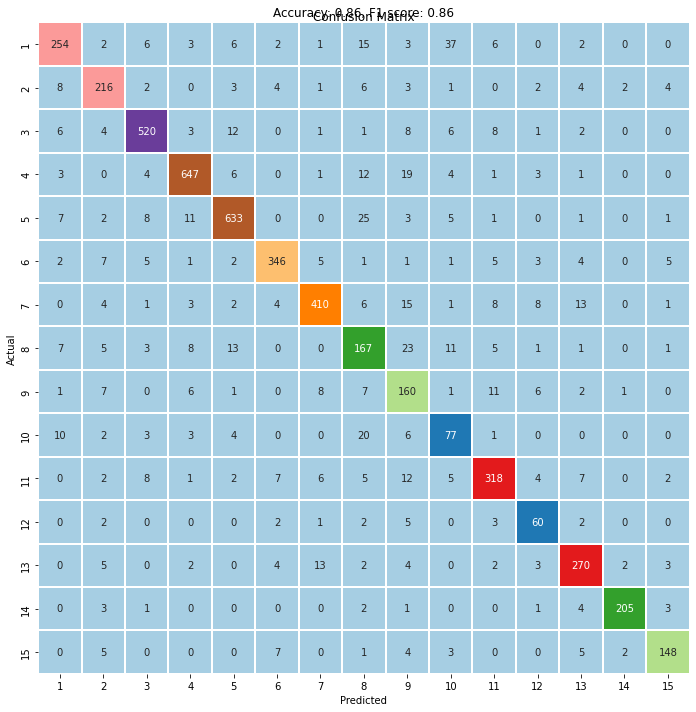

In [ ]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.85      0.75      0.80       337
           2       0.81      0.84      0.83       256
           3       0.93      0.91      0.92       572
           4       0.94      0.92      0.93       701
           5       0.93      0.91      0.92       697
           6       0.92      0.89      0.91       388
           7       0.92      0.86      0.89       476
           8       0.61      0.68      0.65       245
           9       0.60      0.76      0.67       211
          10       0.51      0.61      0.55       126
          11       0.86      0.84      0.85       379
          12       0.65      0.78      0.71        77
          13       0.85      0.87      0.86       310
          14       0.97      0.93      0.95       220
          15       0.88      0.85      0.86       175

    accuracy                           0.86      5170
   macro avg       0.82      0.83      0.82      5170
weighted avg       0.86   

printing precision recall f1-score of the 15 SDGS

In [ ]:
vectoriser = pipe['vectoriser']
selector = pipe['selector']
clf = pipe['clf']

top_n = 15
features =  pipe['vectoriser'].get_feature_names_out()
if selector is not None:
    features = features[selector.get_support()]
axis_names = [f'freature_{x + 1}' for x in range(top_n)]

if len(clf.classes_) > 2:
    results = list()
    for c, coefs in zip(clf.classes_, clf.coef_):
        idx = coefs.argsort()[::-1][:top_n]
        results.extend(tuple(zip([c] * top_n, features[idx], coefs[idx])))
else:
  coefs = clf.coef_.flatten()
  idx = coefs.argsort()[::-1][:top_n]
  results = tuple(zip([clf.classes_[1]] * top_n, features[idx], coefs[idx]))

df_lambda = pd.DataFrame(results, columns =  ['sdg', 'feature', 'coef'])
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (225, 3)


,sdg,feature,coef
0,1,poverty,13.091357
1,1,poor,7.180285
2,1,income,4.733363
3,1,children,4.498303
4,1,deprivation,4.315738


In [ ]:
import pickle
filename = 'final_model.sav'
pickle.dump(pipe, open(filename, 'wb'))

load_model = pickle.load(open(filename, 'rb'))

creating a pickle file to store the weights of the model